# Simulating Light-Curves with a Cadence

This notebook demonstrates the simulation of normal Type Ia Supernova (SN Ia) light-curves using realistic cadences and atmospheric variability expected from LSST. To achieve this we use data from the PLaSTICC simulations to establish the cadence, light-curve parameters, and location of SNe observed by LSST. Light-curves with customized time-variable PWV transmission effects are then simulated using these parameters.

Plots in this notebook are rendered using a subset of demo PLaSTICC data included ib the project repository.
To access a larger data set, configure your working environment as outlined [in the docs](https://lsstdesc.org/SN-PWV/overview/install.html).


In [1]:
import sys

sys.path.insert(0, '../')

import numpy as np
import sncosmo
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import vstack
from matplotlib import pyplot as plt
from pwv_kpno.gps_pwv import GPSReceiver

from snat_sim import models, constants as const
from snat_sim.plasticc import PLaSTICC


In [2]:
plt.rcParams['figure.dpi'] = 100


## The PLaSTICC Data

Instead of evaluating different cadences from scratch, we take the PLaSTICC simulations as a starting point. First we check what cadence simulations are available on the notebook's host server.


In [3]:
PLaSTICC.get_available_cadences()


['alt_sched']

Simulated light-curves are written in the SNANA file format and are distributed across multiple files. We load a light-curve from one of these files and demonstrate the data model below. Each cadence includes simulations run with multiple supernova models. In this notebook we only need simulations for normal SNe (Model 11).


In [4]:
alt_sched = PLaSTICC('alt_sched', 11)
demo_header_files = alt_sched.get_model_headers()
print('Available Light-curves: ', alt_sched.count_light_curves())
    

Available Light-curves:  115


In [5]:
# Data is loaded into memory in chunks. This cell may take a second.
plasticc_lc = next(alt_sched.iter_lc(verbose=False))


In [6]:
print('Params:')
print({
    't0': plasticc_lc.meta['SIM_PEAKMJD'],
    'x1': plasticc_lc.meta['SIM_SALT2x1'],
    'c': plasticc_lc.meta['SIM_SALT2c'],
    'z': plasticc_lc.meta['SIM_REDSHIFT_CMB'],
    'x0': plasticc_lc.meta['SIM_SALT2x0']
})

plasticc_lc


Params:
{'t0': 61999.68359375, 'x1': -0.7346711158752441, 'c': 0.05709853768348694, 'z': 0.43570369482040405, 'x0': 1.3367582141654566e-05}


MJD,FLT,FIELD,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,SKY_SIG,ZEROPT,SIM_MAGOBS
float64,str2,str12,int32,float32,float32,float32,float32,float32,float32,float32
61954.3306,z,NULL,0,0.0,15.283731,20.61587,2.75,47.32,30.89,98.98417
61954.3496,g,NULL,0,0.0,3.0582032,4.2619643,2.78,13.68,31.29,98.96046
61958.423,Y,NULL,0,0.0,-34.665913,24.074171,1.89,74.22,30.8,98.98663
61960.3473,r,NULL,0,0.0,-2.3959112,10.888871,1.54,83.51,31.58,98.97268
61960.3667,i,NULL,0,0.0,-11.10509,10.491764,1.49,64.03,31.29,98.9793
61962.3822,r,NULL,0,0.0,0.25858268,12.420084,2.32,65.6,31.62,98.97268
61962.4021,z,NULL,0,0.0,15.907692,15.589854,1.98,53.47,30.97,98.98417
61965.4071,i,NULL,0,0.0,5.3211513,9.46272,1.99,43.6,31.3,98.9793
61965.4287,z,NULL,0,0.0,2.6012752,13.66771,1.95,47.65,30.97,98.98417


Here we reformat the data to be compatible with `sncosmo` so we can easily visualize the light-curve.


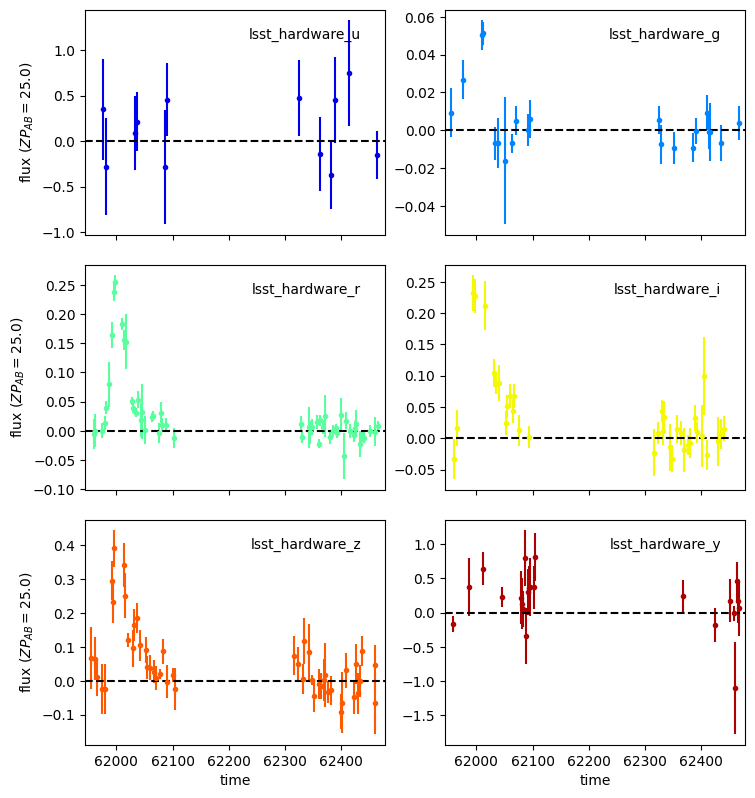

In [7]:
formatted_lc = PLaSTICC.format_data_to_sncosmo(plasticc_lc)
sncosmo.plot_lc(formatted_lc);


## Simulating Light-Curves

Since we need to add in our own atmospheric variability, the pre-tabulated flux values above are of limited use. Instead, we use the PLaSTICC meta-data to establish the cadence and model parameters for each simulated SN. This information is then used to simulate our own light-curves with `sncosmo`.


In [8]:
params, plasticc_cadence = models.ObservedCadence.from_plasticc(plasticc_lc, zp=30)

model_for_sim = models.SNModel('salt2-extended')
model_for_sim.update({p: v for p, v in params.items() if p in model_for_sim.param_names})
model_for_sim.set_source_peakabsmag(const.betoule_abs_mb, 'standard::b', 'AB', cosmo=const.betoule_cosmo)
duplicated_lc = model_for_sim.simulate_lc(plasticc_cadence)


In [9]:
duplicated_lc

time,band,flux,fluxerr,zp,zpsys
float64,str15,float64,float64,float64,str8
61954.3306,lsst_hardware_z,-13.665870468496921,47.31999969482422,30.0,AB
61954.3496,lsst_hardware_g,0.9093540818869735,13.680000305175781,30.0,AB
61958.423,lsst_hardware_y,-6.6410145033541506,74.22000122070312,30.0,AB
61960.3473,lsst_hardware_r,-6.3733669294747735,83.51000213623047,30.0,AB
61960.3667,lsst_hardware_i,44.720882838850564,64.02999877929688,30.0,AB
61962.3822,lsst_hardware_r,148.46202426817877,65.5999984741211,30.0,AB
61962.4021,lsst_hardware_z,5.454051479834469,53.470001220703125,30.0,AB
61965.4071,lsst_hardware_i,-40.52084896413084,43.599998474121094,30.0,AB
61965.4287,lsst_hardware_z,-12.013756179279966,47.650001525878906,30.0,AB


When comparing our own "duplicated" light-curves with the original PLaSTICC simulations, we care about three things:
1. Do the light-curves have the same time sampling?
2. Do the light-curves have the same parameters (except for x0 which depends on the spectral template and cosmology)?
3. Do the light-curves have a similar SNR?

The time sampling is easily verified by looking at the plotted data:

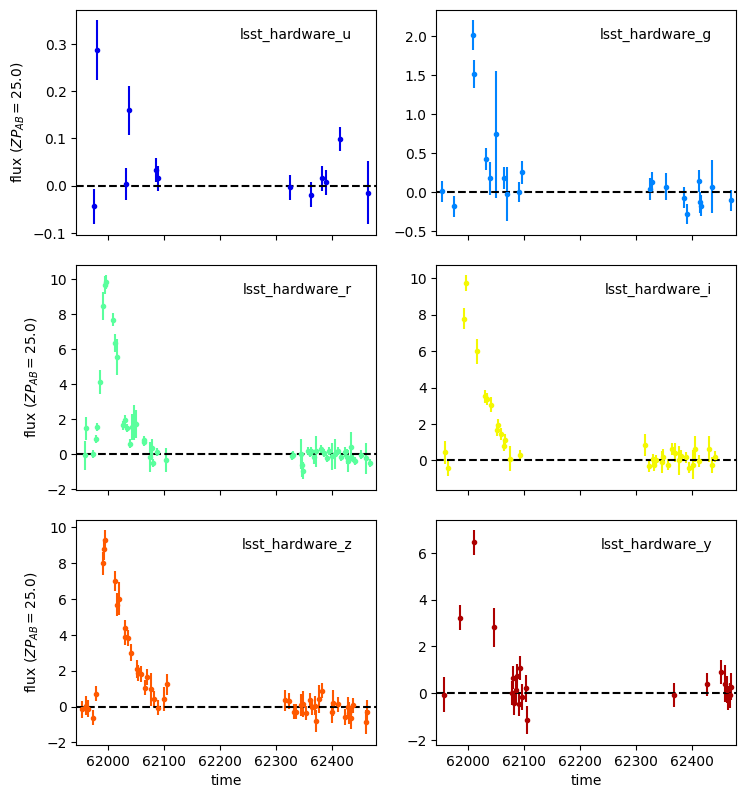

In [10]:
sncosmo.plot_lc(duplicated_lc);


Similarly we can check the light-curve parameters:

In [11]:
duplicated_lc.meta


{'z': 0.43570369482040405,
 't0': 61999.68359375,
 'x0': 1.1405574385929165e-05,
 'x1': -0.7346711158752441,
 'c': 0.05709853768348694}

For the SNR it is more informative to look at a distribution over many light-curves:

In [12]:
def plot_snr_distributions(lc_list, bins=np.arange(-10, 16)):
    """Plot the SNR distribution in each band for PLaSTICC light-curves and their duplicates
    
    Args:
        lc_list (List[Table]): List of light-curves in the PLaSTICC data model
        bins          (array): Bins to use when generating the histogram
    """
    
    # Simulate and accumulate duplicate light-curves
    plasticc_lcs = []
    sncosmo_lcs = []
    for plasticc_lc in lc_list:
        try:
            params, plasticc_cadence = models.ObservedCadence.from_plasticc(plasticc_lc, zp=30)

            model_for_sim = models.SNModel('salt2-extended')
            model_for_sim.update({p: v for p, v in params.items() if p in model_for_sim.param_names})
            model_for_sim.set_source_peakabsmag(const.betoule_abs_mb, 'standard::b', 'AB', cosmo=const.betoule_cosmo)
            duplicated_lc = model_for_sim.simulate_lc(plasticc_cadence)

        except:
            continue

        plasticc_lcs.append(PLaSTICC.format_data_to_sncosmo(plasticc_lc))
        sncosmo_lcs.append(duplicated_lc)

    combined_plasticc = vstack(plasticc_lcs, metadata_conflicts='silent')
    combined_sncosmo = vstack(sncosmo_lcs, metadata_conflicts='silent')
    lc_data_sets = [combined_plasticc, combined_sncosmo]

    fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex='col', sharey=True)
    for combined_data, axis_row in zip(lc_data_sets, axes):
        for band, axis in zip('ugrizy', axis_row):
            band_data = combined_data[combined_data['band'] == 'lsst_hardware_' + band]
            snr = (band_data['flux'] / band_data['fluxerr'])
            avg = np.average(snr)
            std = np.std(snr)
            
            axis.hist(snr, alpha=.5, bins=bins)
            axis.axvline(avg, linestyle='--', color='k', label=f'Average = {avg: .2f}')
            axis.axvline(avg - std, linestyle=':', color='k', label=f'Stdev = {std: .2f}')
            axis.axvline(avg + std, linestyle=':', color='k')
            
            axis.set_title(band)
            axis.set_xlim(min(bins), max(bins))
            axis.legend()
            
    for axis in axis_row:
        axis.set_xlabel('SNR')
            
    axes[0, 0].set_ylabel('PLaSTICC')
    axes[1, 0].set_ylabel('SNCosmo')
    
    plt.show()


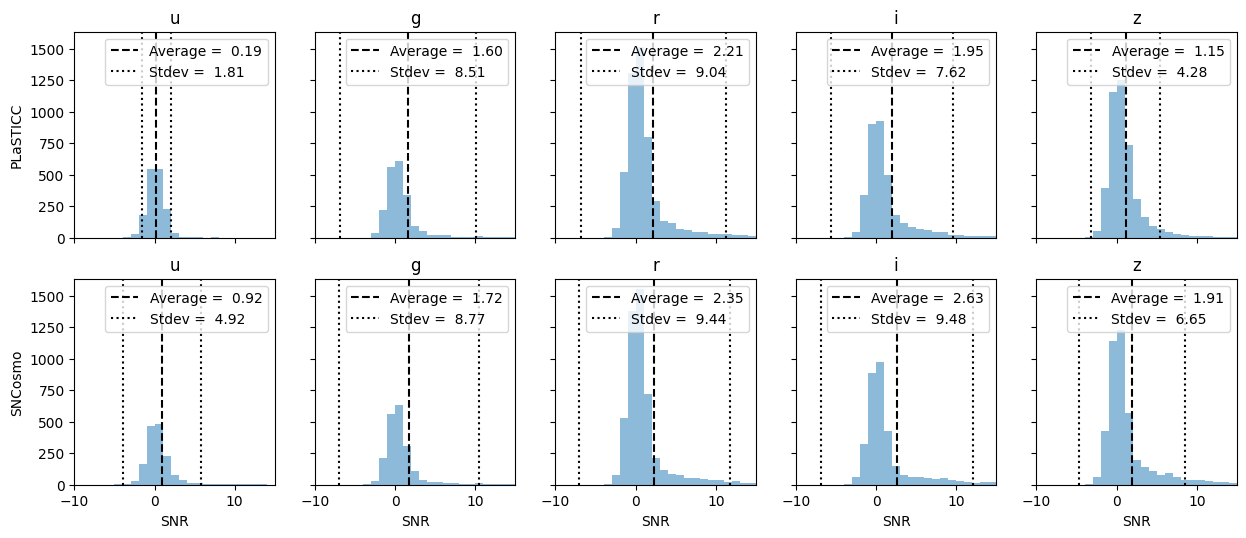

In [13]:
# This line may take a moment while the image renders
plot_snr_distributions(list(alt_sched.iter_lc(iter_lim=1000, verbose=False)))


## Adding Atmospheric Effects

To simulate light-curves with PWV effects, we need a model for the PWV over time. This is easily defined as follows:

In [14]:
ctio = GPSReceiver('CTIO', data_cuts={'PWV': [(0, 25)]})
ctio.download_available_data(year=range(2012, 2018))
pwv_model = models.PWVModel.from_suominet_receiver(ctio, 2016, [2017])


Next we need a SN Model that incorporates the PWV concentration along line of sight (i.e. the PWV scaled for the airmass at the time of observation). The `sncosmo` package doesn't have a clearly defined approach to adding time variable propagation effects. We use custom classes from the `snat_sim` package instead, which mimic `sncosmo` but include time variable propagation effects.

In [15]:
pwv_effect = models.VariablePWVTrans(pwv_model)

demo_model_with_pwv = models.SNModel(
    source='salt2-extended',
    effects=[pwv_effect],
    effect_names=[''],
    effect_frames=['obs']
)


In [16]:
def plot_variable_pwv_sn_model(model_with_pwv, phase=0, params=None):
    """Over plot a sncosmo model with and without temporally variable PWV
    
    Args:
        model_with_pwv (SNModel): sncosmo source to plot
        phase            (float): Phase of the supernova to plot
        params            (dict): Non-PWV related parameters for the model
    """

    params = params or dict()
    wave = np.arange(3000, 12000)
    time = phase + params.get('t0', 0)

    model_without_pwv = sncosmo.Model(model_with_pwv.source)
    model_without_pwv.update({k: v for k, v in params.items() if k in model_without_pwv.param_names})
    flux_without_pwv = model_without_pwv.flux(time, wave)

    model_with_pwv.update(params)
    flux_with_pwv = model_with_pwv.flux(time, wave)

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.plot(wave, flux_without_pwv, label='Base Model', color='C1')
    ax.plot(wave, flux_with_pwv, label='Model with PWV', color='C0')
    ax.set_title('Simulated Flux')
    ax.set_ylabel('Flux')
    ax.legend()
    ax.set_xlabel('Wavelength (A)')
    ax.set_xlim(min(wave), max(wave))

    plt.tight_layout()


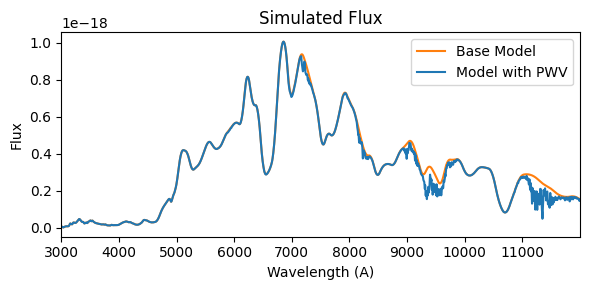

In [17]:
plot_variable_pwv_sn_model(
    demo_model_with_pwv,     
    params = {
        'z': 0.752069652,
        'x0': 3e-06,
        'x1': -1.8,
        'c': -0.1,
    }
)


The PWV along line of sight is equivalent to the PWV at zenith times the airmass of the observation.
We quickly validate the airmass calculation of the `VariablePWVTrans` class.


In [18]:
def plot_airmass_validation(cadence, model=11, mjd=0):
    """Plot the airmass of simulated PLaSTICC SNe locations as observed from LSST
    
    Args:
        cadence_name (PLaSTICC): Simulated PLaSTICC cadence to plot SNe for
        mjd             (float): Date to plot airmasses for
    """
    
    ra = []
    dec = []
    peak = []

    header_path = cadence.get_model_headers()[0]
    header_data = fits.open(header_path)[1].data
    ra.extend(header_data['RA'])
    dec.extend(header_data['DECL'])
    
    if mjd == 'peak':
        peak.extend(header_data['PEAKMJD'])

    if mjd == 'peak':
        mjd = peak
    
    airmass = models.PWVModel.calc_airmass(time=mjd, ra=ra, dec=dec)
    is_positive_airmass = np.array(airmass) >= 0 
    positive_airmass = airmass[is_positive_airmass]
    
    sn_coord = SkyCoord(ra, dec, unit=u.deg).galactic
    positive_coords = sn_coord[is_positive_airmass]
    negative_coords = sn_coord[~is_positive_airmass]
    
    plt.figure(figsize=(10, 5))
    plt.subplot(111, projection='aitoff')
    plt.grid(True)
    
    scat = plt.scatter(positive_coords.l.wrap_at('180d').radian, positive_coords.b.radian, c=positive_airmass, vmin=1, vmax=8, s=10)
    plt.scatter(negative_coords.l.wrap_at('180d').radian, negative_coords.b.radian, c='lightgrey', label='Over Horizon')
    plt.legend(framealpha=1)
    plt.colorbar(scat).set_label('Airmass', rotation=270, labelpad=15)
    

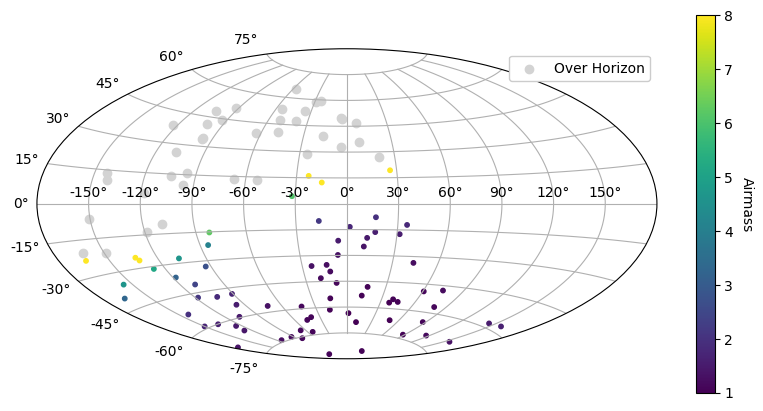

In [19]:
plot_airmass_validation(alt_sched)
